In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import string

# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer 
# from nltk.tokenize import word_tokenize
# from nltk.corpus import words
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

import warnings
warnings.filterwarnings('ignore')

### Train, Valid, and Test + Vectorisation 

In [2]:
train_data = pd.read_csv('train_data.csv')
train_data.drop('Unnamed: 0', axis = 1)

,Review,Cleaned_Review,Category
0,Room quality.. hotel staff.. the bar..,room quality hotel staff bar,1
1,"The bed, size of room, the bath tub feature in...",bed size room bath tub feature bathroom location,1
2,I was made very welcome at the britania Hotel ...,make welcome britania hotel exerlent reception...,1
3,Location was brilliant.,location brilliant,1
4,Syl checked me in. She was friendly and profes...,syl check friendly professional offer upgrade ...,1
...,...,...,...
20668,No Negative,negative,0
20669,concierge was uninformed,concierge uninformed,0
20670,I had no complaints,complaints,0
20671,Really shabby and run down hotel Needs a tota...,really shabby run hotel need total refurbish j...,0


In [3]:
test_data = pd.read_csv('test_data.csv')
test_data = test_data[['Unnamed: 0', 'Review', 'Cleaned_Review', 'Category']]
test_data.drop('Unnamed: 0', axis = 1)

,Review,Cleaned_Review,Category
0,All ok except the cost of parking We had a bud...,ok except cost park budget night stay well set...,1
1,Bad experience overall I had the worse experie...,bad experience overall worse experience ever f...,0
2,Better than expected stayed as part of a natio...,better expect stay part national coach trip pl...,1
3,Dismal I booked a double room six months in ad...,dismal book double room six months advance sta...,0
4,Good value for weekend break Service was very ...,good value weekend break service good room lar...,1
...,...,...,...
1645,Worst Hotel in London Me and my friend booked ...,worst hotel london friend book nights leave ho...,0
1646,Would not recommend I was given a room in the ...,would not recommend give room basement felt li...,0
1647,Wouldn’t stay again- don’t recommend The inter...,would not stay not recommend interior old ward...,0
1648,"Beautiful lobby, Tired rooms, Rude staff We ar...",beautiful lobby tire room rude staff arrive pa...,0


In [4]:
X = train_data.Cleaned_Review

y = train_data.Category

X = X.astype('str')

y = y.astype('float64')

X_test = test_data.Cleaned_Review
y_test = test_data.Category

X_test = X_test.astype('str')
y_test = y_test.astype('str')

In [5]:
%%time
# TFIDF 

# create a TFIDF vectorizer object 
tfidf_vect = TfidfVectorizer(analyzer = 'word', token_pattern = r'\w{1,}')


# transform the training and validation data using count vectorizer object

X_count = tfidf_vect.fit_transform(X)
X_test_count = tfidf_vect.transform(X_test)

Wall time: 324 ms


In [6]:
X_count = X_count.astype('float64')
# X_train_count = X_train_count.astype('float64')
# X_valid_count = X_valid_count.astype('float64')
X_test_count = X_test_count.astype('float64')

y = y.astype('float64')
# y_train = y_train.astype('float64')
# y_valid = y_valid.astype('float64')
y_test = y_test.astype('float64')

### MNB

In [7]:
%%time 

mnb_params = {
    'alpha' : [0.7, 0.8, 0.9, 1]
}

nb = MultinomialNB()

clf = GridSearchCV(nb, mnb_params,cv= 5)
clf.fit(X_count, y)

print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)


Best Score:  0.844343419275317
Best Params:  {'alpha': 1}
Wall time: 152 ms


In [8]:
nb = MultinomialNB(alpha = clf.best_params_['alpha'])
nb.fit(X_count, y)

MultinomialNB(alpha=1)

In [9]:
MNB_prediction_1 = nb.predict(X_test_count)
MNB_prediction_1

array([1., 0., 1., ..., 0., 0., 1.])

In [10]:
f1score_MNB = f1_score(y_test, MNB_prediction_1, average = 'macro')
print('MNB, Count Vectors: {0:.5f}%'.format(f1score_MNB*100))

accuracy_MNB = accuracy_score(y_test, MNB_prediction_1)
print('Accuracy: {0:.5f}%'.format(accuracy_MNB*100))

print()
print(classification_report(y_test, MNB_prediction_1))

MNB, Count Vectors: 79.71643%
Accuracy: 83.09091%

              precision    recall  f1-score   support

         0.0       0.92      0.84      0.88      1212
         1.0       0.65      0.80      0.71       438

    accuracy                           0.83      1650
   macro avg       0.78      0.82      0.80      1650
weighted avg       0.85      0.83      0.84      1650



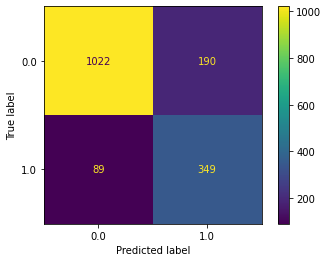

In [11]:
plot_confusion_matrix(nb, X_test_count, y_test)  
plt.show()  

### Logistic Regression

In [12]:
%%time

lr = LogisticRegression(random_state = 123)

lr_params = {
    'solver' : ['lbfgs', 'liblinear'], #'sag', 'newton-cg'
    'penalty': ['l2'],
    'C': [10, 1.0, 0.1, 0.01],
    'max_iter': [100, 150, 200, 300]
}



clf = GridSearchCV(lr, lr_params, cv= 5)
clf.fit(X_count, y)

print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)


Best Score:  0.839166799753599
Best Params:  {'C': 1.0, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Wall time: 27.8 s


In [13]:
lr = LogisticRegression(random_state = 123, C = clf.best_params_['C'],
                         max_iter = clf.best_params_['max_iter'],
                         penalty = clf.best_params_['penalty'],
                         solver = clf.best_params_['solver'])
lr.fit(X_count, y)

LogisticRegression(random_state=123)

In [14]:
lr_prediction= lr.predict(X_test_count)
lr_prediction

array([1., 0., 1., ..., 0., 0., 1.])

In [15]:
f1score_lr = f1_score(y_test, lr_prediction, average = 'macro')
print('LR, Count Vectors: {0:.5f}%'.format(f1score_lr*100))

accuracy_lr = accuracy_score(y_test, lr_prediction)
print('Accuracy: {0:.5f}%'.format(accuracy_lr*100))

print()
print(classification_report(y_test, lr_prediction))

LR, Count Vectors: 78.16942%
Accuracy: 81.21212%

              precision    recall  f1-score   support

         0.0       0.93      0.81      0.86      1212
         1.0       0.61      0.83      0.70       438

    accuracy                           0.81      1650
   macro avg       0.77      0.82      0.78      1650
weighted avg       0.84      0.81      0.82      1650



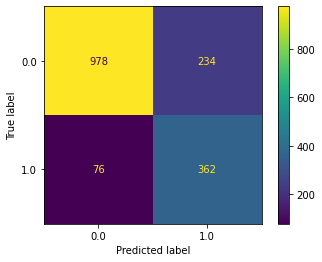

In [16]:
plot_confusion_matrix(lr, X_test_count, y_test)  
plt.show()  

### SVM

In [17]:
%%time

svm = SGDClassifier(loss = 'hinge', random_state = 123)

svm_params = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], 
    'max_iter': [200,300,500,700,1000],
    'penalty': ['l2'],
}



clf = GridSearchCV(svm, svm_params, cv= 5)
clf.fit(X_count, y)

print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)

Best Score:  0.845068593882447
Best Params:  {'alpha': 0.0001, 'max_iter': 200, 'penalty': 'l2'}
Wall time: 5.07 s


In [18]:
svm = SGDClassifier(loss = 'hinge', alpha = clf.best_params_['alpha'],
          penalty = clf.best_params_['penalty'],
          max_iter = clf.best_params_['max_iter'],
          random_state = 123)

svm.fit(X_count, y)

SGDClassifier(max_iter=200, random_state=123)

In [19]:
svm_prediction = svm.predict(X_test_count)
svm_prediction

array([1., 0., 1., ..., 0., 0., 1.])

In [20]:
f1score_svm = f1_score(y_test, svm_prediction, average = 'macro')
print('SVM, Count Vectors: {0:.5f}%'.format(f1score_svm *100))

accuracy_svm = accuracy_score(y_test, svm_prediction)
print('Accuracy: {0:.5f}%'.format(accuracy_svm*100))

print()
print(classification_report(y_test, svm_prediction))

SVM, Count Vectors: 78.85863%
Accuracy: 82.30303%

              precision    recall  f1-score   support

         0.0       0.92      0.83      0.87      1212
         1.0       0.63      0.79      0.70       438

    accuracy                           0.82      1650
   macro avg       0.78      0.81      0.79      1650
weighted avg       0.84      0.82      0.83      1650



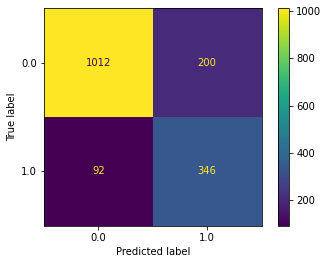

In [21]:
plot_confusion_matrix(svm, X_test_count, y_test)  
plt.show()  